In [220]:
# Data loading
from utils import load_data

# Optimization (Optuna)
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# metrics / evaluation
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from numpy import rint
from numpy import load
from numpy import concatenate

# datetime
import datetime

# xgboost
import xgboost as xgb
from xgboost import XGBClassifier

In [244]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(win_size=150)

Samples fetched
Data fetched
all_samples shape: (194, 200, 7)
all_labels shape: (194,)
X_train shape: (135, 200, 7)
X_val shape: (30, 200, 7)
X_test shape: (29, 200, 7)
X_train shape: (1632, 150, 7), 1/0 ratio: 0.7022058823529411
X_val shape: (373, 150, 7), 1/0 ratio: 0.710455764075067
X_test shape: (373, 150, 7), 1/0 ratio: 0.7265415549597856


In [230]:
# merge X_train, X_val, X_test, y_train, y_val, y_test
X = concatenate((X_train, X_val, X_test))
y = concatenate((y_train, y_val, y_test))

In [231]:
# split X, y into 0 and 1 samples
X_0 = X[y == 0]
X_1 = X[y == 1]

count    116.000000
mean       0.001318
std        0.002670
min        0.000001
25%        0.000149
50%        0.000461
75%        0.001273
max        0.016668
dtype: float64
count    78.000000
mean      0.008196
std       0.006161
min       0.000562
25%       0.003442
50%       0.006348
75%       0.011002
max       0.025104
dtype: float64


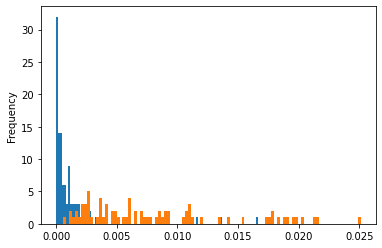

In [69]:
vars_0 = []
for sample in X_0:
    vars_0.append(sample[:,0:3].var())

vars_1 = []
for sample in X_1:
    vars_1.append(sample[:,0:3].var())

series_0 = pd.Series(vars_0)
series_1 = pd.Series(vars_1)

print(series_0.describe())
print(series_1.describe())

# plot the distribution of the variances
series_0.plot(kind='hist', bins=100)
series_1.plot(kind='hist', bins=100)
plt.show()

In [159]:
# disable scientific notation
np.set_printoptions(suppress=True)

In [163]:
sample.quantile(0.25, axis=0)

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [245]:
from scipy.stats import skew, kurtosis

def get_stats(X,y):
    X_stats = []
    labels = []

    for i, sample in enumerate(X):
        sample_stats = {}
        sample_stats['var'] = sample.var(axis=0)
        sample_stats['min'] = sample.min(axis=0)
        sample_stats['max'] = sample.max(axis=0)
        sample_stats['skew'] = skew(sample, axis=0)
        sample_stats['kurtosis'] = kurtosis(sample, axis=0)
        sample_stats['q025'] = np.percentile(sample, q=2.5, axis=0)
        sample_stats['q25'] = np.percentile(sample, q=25, axis=0)
        sample_stats['q50'] = np.percentile(sample, q=50, axis=0)
        sample_stats['q75'] = np.percentile(sample, q=75, axis=0)
        sample_stats['q95'] = np.percentile(sample, q=95, axis=0)

        X_stats.append(pd.DataFrame(sample_stats))

        # add label according to the value of y at the index of sample in X
        labels.append(y[i])

    return np.array(X_stats), np.array(labels)

In [233]:
X_stats = np.stack(X_stats)
labels = np.stack(labels)

In [234]:
print(X_stats.shape)

(2378, 7, 10)


In [246]:
X_train, y_train = get_stats(X_train, y_train)
X_val, y_val = get_stats(X_val, y_val)
X_test, y_test = get_stats(X_test, y_test)

In [250]:
# flatten X_train and X_val and X_test for Naive Bayes, XGBoost
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

## XGBoost

In [252]:
# tune the hyperparameters
def objective(trial):
    # define the hyperparameters to tune
    eta = trial.suggest_loguniform("eta", 0.01, 1.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 50)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    scale_pos_weight = trial.suggest_uniform("scale_pos_weight", 1, 50)
    subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
    gamma = trial.suggest_uniform("gamma", 0.0, 10.0)

    # define the model
    model = XGBClassifier(
        eta=eta, min_child_weight=min_child_weight, max_depth=max_depth,  scale_pos_weight=scale_pos_weight, subsample=subsample, gamma=gamma
    )
    # fit the model
    model.fit(X_train, y_train)
    # predict the test data
    preds = model.predict(X_val)
    pred_labels = np.rint(preds)
    #recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    f_score = f1_score(y_val, pred_labels)
    return f_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.9850746268656716
  Params: 
    eta: 0.04425235169747014
    min_child_weight: 17
    max_depth: 50
    scale_pos_weight: 26.189327078819705
    subsample: 0.9280971750601683
    gamma: 0.03710988793351788


In [253]:
# build the best model
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params)
# fit the model
best_model.fit(X_train, y_train)
# predict the test data
pred_xgb = best_model.predict(X_test)
# get the f1 score
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.76       102
         1.0       0.87      1.00      0.93       271

    accuracy                           0.90       373
   macro avg       0.94      0.81      0.85       373
weighted avg       0.91      0.90      0.89       373



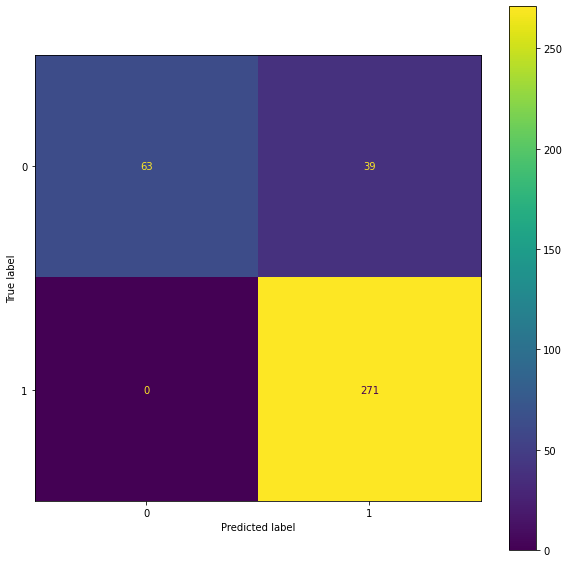

In [254]:
# get confusion matrix
plt.rcParams['figure.figsize'] = (10, 10)

cm = confusion_matrix(y_test, pred_xgb)
# plot confusion matrix

cm = confusion_matrix(y_test, pred_xgb, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

In [255]:
optuna.visualization.plot_param_importances(study)

In [256]:
optuna.visualization.plot_optimization_history(study)

In [257]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [219]:
# save the model
best_model.save_model("../models/xgb-capybara-2.bin")

#load the model
#model = xgb.Booster(model_file="../models/xgb_model_2.bin")
# predict the test data
#model.predict(xgb.DMatrix(X_test))

## Evaluation

In [98]:
def predict(X: np.array) -> np.array:
    preds = []
    for sample in X:
        var = sample[:,0:3].var()
        if var > 0.002:
            preds.append(1)
        else:
            preds.append(0)
    return np.array(preds)

In [92]:
preds = predict(X_test)
print(preds)

[0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0]


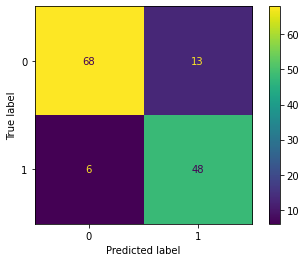

In [100]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

preds = predict(X_train)
pred_labels = rint(preds)

# get confusion matrix
#plt.rcParams['figure.figsize'] = (10, 10)

# plot confusion matrix

cm = confusion_matrix(y_train, pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()